In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Task #2 - Traffic Jams in the City

You need to write a program that takes as input an image that schematically shows a car on a road with $N$ lanes and obstacles on the lanes. The corresponding objects are marked with colors that remain consistent across all images.

The result of the program is the lane number to which you need to change lanes, or a message that no lane change is needed.

**Evaluation:**

Successfully solving at least one image gives 50% of the total points, and 25% for each subsequent one.

**Note: lane numbers are counted from left to right, starting from zero.**

Example images:

| Image 1 | Image 2 |
|---------|---------|
| ![image_00](https://i.ibb.co/8z84sJG/image_00.jpg) | ![image_01](https://i.ibb.co/Z6m4XFz/image_01.jpg) |

## Task Summary:
- **Input**: Image showing a car on a multi-lane road with obstacles
- **Objects**: Car and obstacles marked with consistent colors
- **Output**: Lane number to switch to (0-indexed from left), or "no change needed"
- **Scoring**: 50% for solving 1 image, +25% for each additional

This is a **lane detection and obstacle avoidance** computer vision problem.

In [2]:
def find_yellow_lane_coordinates(image_path):
    """
    Find (x,y) coordinates of yellow lane separators from a single line at the top
    """
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not load image from {image_path}")
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    y_line = 0 
    top_line = yellow_mask[y_line, :] 
    
    yellow_x_positions = np.where(top_line > 0)[0]
    
    if len(yellow_x_positions) == 0:
        return []
    
    grouped_coords = []
    current_group = [yellow_x_positions[0]]
    
    for i in range(1, len(yellow_x_positions)):
        if yellow_x_positions[i] - yellow_x_positions[i-1] <= 5:
            current_group.append(yellow_x_positions[i])
        else:
            if len(current_group) > 10: 
                avg_x = int(np.mean(current_group))
                grouped_coords.append((avg_x, y_line))
            current_group = [yellow_x_positions[i]]

    if len(current_group) > 10:
        avg_x = int(np.mean(current_group))
        grouped_coords.append((avg_x, y_line))
    
    return grouped_coords

In [ ]:
def create_lane_regions(image_path):
    """
    Create regions of interest for each lane between successive yellow lines
    """
    yellow_coords = find_yellow_lane_coordinates(image_path)
    
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    
    yellow_coords = sorted(yellow_coords, key=lambda coord: coord[0])
    x_positions = [coord[0] for coord in yellow_coords]
    
    lane_regions = []
    
    if len(x_positions) > 0 and x_positions[0] > 20:
        left_roi = {
            'lane_id': 0,
            'x_start': 0,
            'x_end': x_positions[0],
            'y_start': 0,
            'y_end': height,
            'coordinates': [(0, 0), (x_positions[0], 0), (x_positions[0], height), (0, height)]
        }
        lane_regions.append(left_roi)
    
    for i in range(len(x_positions) - 1):
        x_start = x_positions[i]
        x_end = x_positions[i + 1]
        
        lane_roi = {
            'lane_id': i + 1,
            'x_start': x_start,
            'x_end': x_end,
            'y_start': 0,
            'y_end': height,
            'coordinates': [(x_start, 0), (x_end, 0), (x_end, height), (x_start, height)]
        }
        lane_regions.append(lane_roi)
    if len(x_positions) > 0 and x_positions[-1] < width - 20:
        right_roi = {
            'lane_id': len(x_positions),
            'x_start': x_positions[-1],
            'x_end': width,
            'y_start': 0,
            'y_end': height,
            'coordinates': [(x_positions[-1], 0), (width, 0), (width, height), (x_positions[-1], height)]
        }
        lane_regions.append(right_roi)
    
    return lane_regions

In [4]:
def visualize_lane_regions(image_path):
    """
    Visualize each lane as a separate region of interest
    """
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    lane_regions = create_lane_regions(image_path)

    for i, lane in enumerate(lane_regions):
        cv2.rectangle(img_rgb, 
                     (lane['x_start'], lane['y_start']), 
                     (lane['x_end'], lane['y_end']), 
                     (0,0,0), 3)
        
        lane_center_x = (lane['x_start'] + lane['x_end']) // 2
        cv2.putText(img_rgb, f'Lane {lane["lane_id"]}', 
                   (lane_center_x - 30, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.8, (0,0,0), 2)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.title(f'Lane Regions of Interest ({len(lane_regions)} lanes)')
    plt.axis('off')
    plt.show()
    
    return lane_regions

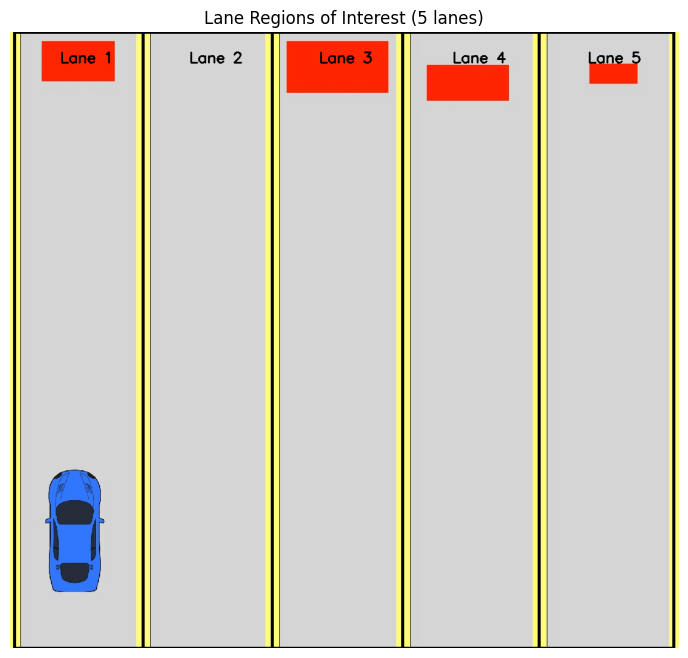

Created 5 lane regions


In [5]:
regions = visualize_lane_regions('task_2/image_00.jpg')
print(f"Created {len(regions)} lane regions")

In [ ]:
def detect_car_and_obstacles_in_lanes(image_path):
    """
    Detect red obstacles and blue car in each lane with boolean indicators
    """
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    lane_regions = create_lane_regions(image_path)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define red color range for obstacles
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([180, 255, 255])
    
    # Create red mask
    red_mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    red_mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)
    
    # Define blue color range for car
    lower_blue = np.array([100, 100, 100])
    upper_blue = np.array([130, 255, 255])
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
    # Check each lane for obstacles and car
    for lane in lane_regions:
        # Extract lane region from masks
        lane_red_mask = red_mask[lane['y_start']:lane['y_end'], 
                                lane['x_start']:lane['x_end']]
        lane_blue_mask = blue_mask[lane['y_start']:lane['y_end'], 
                                  lane['x_start']:lane['x_end']]
        
        # Count pixels in this lane
        red_pixels = np.sum(lane_red_mask > 0)
        blue_pixels = np.sum(lane_blue_mask > 0)
        
        # Set boolean indicators
        lane['has_obstacle'] = red_pixels > 500
        lane['has_car'] = blue_pixels > 500
        lane['red_pixel_count'] = red_pixels
        lane['blue_pixel_count'] = blue_pixels
    
    return lane_regions